In [1]:
import xml.etree.ElementTree as ET
import os
from glob import glob
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine, jaccard, hamming
import numpy as np

### Read data

In [2]:
# Read all song XML files
folder = 'Scientist_Testdata/XML-Projects/'
songs = []
for file in os.listdir(folder):
    root = ET.parse(folder+file).getroot()
    songs.append(root)

In [3]:
# Read all loop csv's
PATH = "Scientist_Testdata/Mix-Packs"
EXT = "*.csv"
all_csv_files = [file for path, subdir, files in os.walk(PATH) for file in glob(os.path.join(path, EXT))]

dfs = []

for f in all_csv_files:
    df = pd.read_csv(f, index_col=0, header=0)
    dfs.append(df)

loops = pd.concat(dfs, axis=0)
# Set filename as index
loops['Filename'] = loops['Filename'].str.slice(start=10)
loops = loops.set_index('Filename')

### Function for getting name and features from csv files

In [4]:
def get_features(loop_name, loops_df):
    """
    Takes a loop name from the XML file in the format “mmj://styles/id/ST_EDM/Bass/DNAC Bass” 
    and returns the correct name and features from the csv files
    :param loop_name: str, loop name from XML file
    :param loops_df: dataframe, the csv files with loop information
    :return: new_name: str, the name from csv file without the prefix
            features: dict, the 8 features (Label, d1, d2 ...)
    """
    # remove "mmj://styles/id/" part in beginning
    name = loop_name[16:]
    
    # find features in loops df
    # try with original name, name+' 1', and name+'  1'
    try:
        features = dict(loops.loc[name])
        return name, features
    except:
        try:
            new_name = name+' 1'
            features = dict(loops.loc[new_name])
        except:
            new_name = name+'  1'
            features = dict(loops.loc[new_name])
    
    return new_name, features

### Function for parsing song to extract information

In [5]:
def parse_song(song, loops_df):
    """
    Parses song and returns dictionary with song information
    :param song: root element, the song in xml format
    :param loops_df: dataframe, the csv files with loop information
    :return: song_info: dict, extracted information about the song
    """
    
    # info about volume, bpm, cut mode
    song_info = song.attrib
    
    # add used chords
    song_info['used_chords'] = song.find('used_chords').text
    
    # number of parts in the song
    parts = song.findall('parts/part')
    song_info['num_parts'] = len(parts)
    
    # loop through parts in song
    parts_dict = {}
    for part in parts:
        part_name = part.attrib['name']
        
        # loop through channels/loops in part
        channels = part.findall('channels/channel')
        channels_dict = {}
        for ch in channels:
            channel_name = ch.attrib['loop']
            if channel_name == '':
                continue
            # get correct name and features from csv files
            correct_name, features = get_features(channel_name, loops_df)
            loop_info = {key:ch.attrib[key] for key in ['volume', 'is_active']}
            loop_info['features'] = features
            channels_dict[correct_name] = loop_info
        
        # Add all channels/loops to part
        parts_dict[part_name] = channels_dict

    song_info['parts'] = parts_dict
    
    return song_info

### Statistics on a song

In [6]:
# Pick a song and extract information
song = songs[10]
song_info = parse_song(song, loops)

In [7]:
song_info.keys()

dict_keys(['volume', 'bpm', 'cut_mode', 'used_chords', 'num_parts', 'parts'])

#### Number of parts

In [8]:
song_info['num_parts']

17

#### Number of loops in parts

In [9]:
for key,value in song_info['parts'].items():
    print('Part:',key)
    print('Number of loops:', len(value))
    print()

Part: Intro
Number of loops: 5

Part: Serene Suspense A
Number of loops: 6

Part: Serene Suspense B
Number of loops: 7

Part: Serene Suspense C
Number of loops: 7

Part: Eerie Build A
Number of loops: 8

Part: Eerie Build B
Number of loops: 8

Part: World Stage A
Number of loops: 8

Part: Loudly Hook A
Number of loops: 8

Part: Loudly Hook B
Number of loops: 8

Part: Serene Supsense D
Number of loops: 5

Part: Serene Suspense E
Number of loops: 7

Part: Transformation
Number of loops: 8

Part: Eerie Build C
Number of loops: 7

Part: World Stage B
Number of loops: 7

Part: Loudly Hook C
Number of loops: 8

Part: Loudly Hook D
Number of loops: 7

Part: End
Number of loops: 8



#### Most used loops in song

In [10]:
used_loops = []
for value in song_info['parts'].values():
    used_loops.extend(value.keys())
used_loops_counts = {x:used_loops.count(x) for x in used_loops}
used_loops_counts = dict(sorted(used_loops_counts.items(), key=lambda x: x[1], reverse=True))

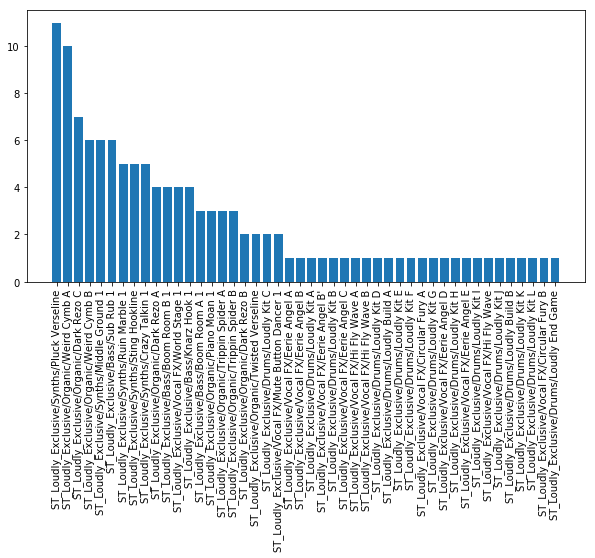

In [11]:
plt.figure(figsize=(10,5))
plt.bar(used_loops_counts.keys(),used_loops_counts.values())
plt.xticks(rotation=90)
plt.show()

#### Most used Mix Pack within the XML project files

In [12]:
used_mix_packs = []
for song in songs:
    try:
        info = parse_song(song, loops)
        parts = info['parts']
        for k,v in parts.items():
            used_mix_packs.extend(list(v.keys()))
    # some loops are not found in the csv files
    except:
        continue
used_mix_packs = [loop.split('/')[0] for loop in used_mix_packs]
used_mix_packs_counts = {x:used_mix_packs.count(x) for x in used_mix_packs}
used_mix_packs_counts = dict(sorted(used_mix_packs_counts.items(), key=lambda x: x[1], reverse=True))
used_mix_packs_counts

{'ST_House_Lite': 3204,
 'ST_Electro_Lite': 3203,
 'ST_Electro_Pop': 3202,
 'ST_Loudly_Exclusive': 2275}

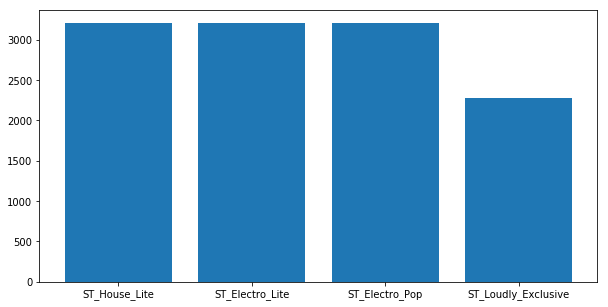

In [160]:
plt.figure(figsize=(10,5))
plt.bar(used_mix_packs_counts.keys(),used_mix_packs_counts.values())
plt.show()

#### Most informative part index in a XML project file

In [ ]:
# I'm sorry, I do not understand what this means

#### Other statistics: BPM

In [167]:
bpms = []
for song in songs:
    try:
        info = parse_song(song, loops)
        bpms.append(int(info['bpm']))
    except:
        continue

In [181]:
print('average bpm:', round(np.mean(bpms),2))
print('fastest song bpm:', np.max(bpms))
print('slowest song bpm:', np.min(bpms))

average bpm: 124.38
fastest song bpm: 195
slowest song bpm: 107


### Similarity between projects

In [102]:
def get_similarity_features(song):
    """
    Gets features for similarity measure: volume, bpm, used_chords, loops
    """
    
    features = []
    
    info = parse_song(song, loops)
    
    features.append(int(info['volume']))
    features.append(int(info['bpm']))
    chords = [char for char in info['used_chords']]
    for i in range(len(chords)):
        if chords[i] == '#':
            chords[i-1] = chords[i-1]+'#'
    chords = [c for c in chords if c != '#']
    features.extend(chords[:4])
    used_loops = []
    for value in info['parts'].values():
        used_loops.extend(value.keys())
    used_loops_counts = {x:used_loops.count(x) for x in used_loops}
    used_loops_top = sorted(used_loops_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    used_loops_top = [item[0] for item in used_loops_top]
    
    features.extend(used_loops_top)
    
    return features

In [127]:
to_df = []
for i in range(0,100):
    try:
        features = get_similarity_features(songs[i])
        to_df.append(features)
    except:
        continue
song_features = pd.DataFrame(to_df, columns = ["volume", "bpm",'chord1', 'chord2', 'chord3', 'chord4','loop1',
                                        'loop2','loop3','loop4','loop5'])
# one hot encode categorical data (chords and loops)
song_features = pd.get_dummies(song_features)

In [131]:
# one hot encode categorical data 
song_features = pd.get_dummies(song_features)

In [158]:
# calculate cosine similarities
print(1 - cosine(song_features.loc[0], song_features.loc[1]))
print(1 - cosine(song_features.loc[10], song_features.loc[20]))
print(1 - cosine(song_features.loc[10], song_features.loc[10]))
print()
# calculate jaccard similarities
print(1 - jaccard(song_features.loc[0], song_features.loc[1]))
print(1 - jaccard(song_features.loc[10], song_features.loc[20]))
print(1 - jaccard(song_features.loc[10], song_features.loc[10]))
print()
# calculate hamming similarities
print(1 - hamming(song_features.loc[0], song_features.loc[1]))
print(1 - hamming(song_features.loc[10], song_features.loc[20]))
print(1 - hamming(song_features.loc[10], song_features.loc[10]))

0.9899460981441038
0.9228517532002813
1.0

0.0
0.25
1.0

0.9352750809061489
0.9611650485436893
1.0
